In [1]:
import os
os.chdir("../../../")

In [2]:
import scanpy as sc
import surgeon
import numpy as np

Using TensorFlow backend.


In [3]:
sc.settings.set_figure_params(dpi=200)

In [4]:
condition_key = "study"
cell_type_key = 'cell_type'
target_conditions = ["Drop-seq", "inDrops"]

# Loading 6 PBMC datasets and data preparation

In [6]:
adata = sc.read("./data/pbmc_subset/pbmc_subset_normalized.h5ad")
adata

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


AnnData object with n_obs × n_vars = 32170 × 1000 
    obs: 'CBC', 'CellType', 'Experiment', 'Method', 'batch', 'bulk_labels', 'cell_type', 'louvain', 'method', 'n_counts', 'n_genes', 'percent_mito', 'study', 'size_factors'
    var: 'ENS-0', 'Name-0', 'gene_ids-1', 'n_counts-2', 'gene_ids-3', 'n_cells-3', 'highly_variable-3', 'means-3', 'dispersions-3', 'dispersions_norm-3'

## Number of cells in each batch

In [7]:
adata.obs[condition_key].value_counts()

10x PBMC 68k         20573
10X_3prime            2429
10X_5prime            2213
inDrops               1975
Drop-seq              1975
10x Chromium V2 B      966
10x Chromium V2 A      966
10x PBMC 3k            791
Smart-seq2             157
CEL-Seq2               125
Name: study, dtype: int64

## visualization  of the original data

In [12]:
sc.pp.neighbors(adata)
sc.tl.umap(adata)

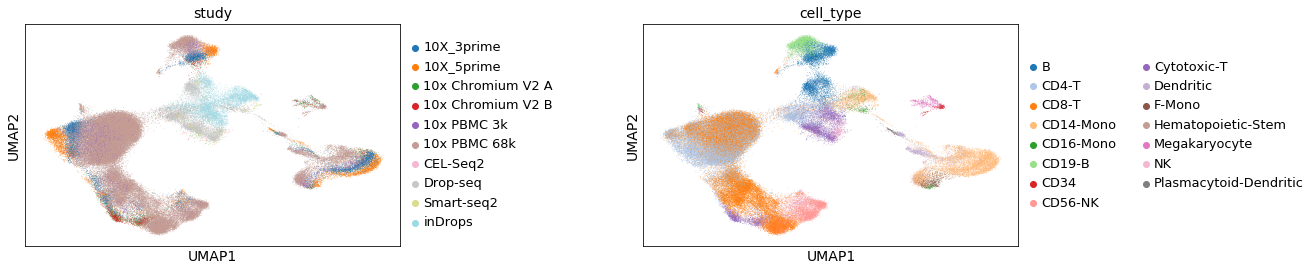

In [13]:
sc.pl.umap(adata, color=[condition_key, cell_type_key], wspace=0.5)

## Now we leave out one study  (Drop-seq) for training the newtork

In [8]:
adata_for_training = adata[~adata.obs[condition_key].isin(target_conditions)]
adata_for_training

View of AnnData object with n_obs × n_vars = 28220 × 1000 
    obs: 'CBC', 'CellType', 'Experiment', 'Method', 'batch', 'bulk_labels', 'cell_type', 'louvain', 'method', 'n_counts', 'n_genes', 'percent_mito', 'study', 'size_factors'
    var: 'ENS-0', 'Name-0', 'gene_ids-1', 'n_counts-2', 'gene_ids-3', 'n_cells-3', 'highly_variable-3', 'means-3', 'dispersions-3', 'dispersions_norm-3'

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


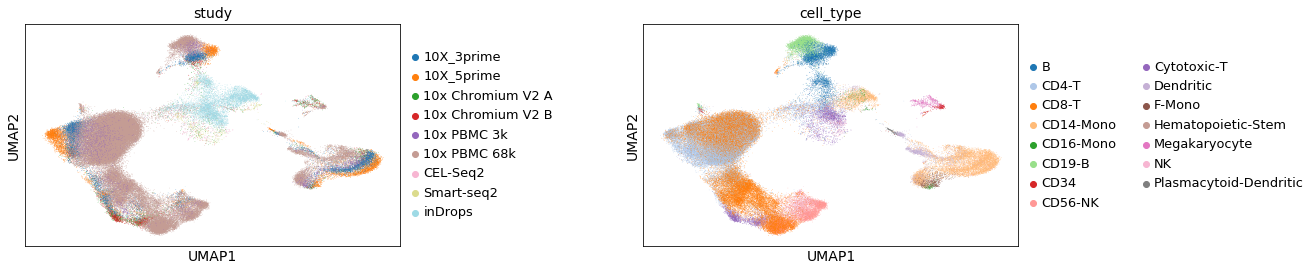

In [15]:
sc.pl.umap(adata_for_training, color=[condition_key, cell_type_key], wspace=0.5)

In [9]:
adata_out_of_sample = adata[adata.obs[condition_key].isin(target_conditions)]
adata_out_of_sample

View of AnnData object with n_obs × n_vars = 3950 × 1000 
    obs: 'CBC', 'CellType', 'Experiment', 'Method', 'batch', 'bulk_labels', 'cell_type', 'louvain', 'method', 'n_counts', 'n_genes', 'percent_mito', 'study', 'size_factors'
    var: 'ENS-0', 'Name-0', 'gene_ids-1', 'n_counts-2', 'gene_ids-3', 'n_cells-3', 'highly_variable-3', 'means-3', 'dispersions-3', 'dispersions_norm-3'

## Train/Test Split

In [10]:
train_adata, valid_adata = surgeon.utils.train_test_split(adata_for_training, 0.85)

In [11]:
train_adata.shape, valid_adata.shape

((23987, 1000), (4233, 1000))

In [12]:
n_conditions = len(train_adata.obs[condition_key].unique().tolist())
n_conditions

8

# Create & Train model with training data

In [13]:
network = surgeon.archs.CVAE(x_dimension=train_adata.shape[1], 
                             z_dimension=20,
                             architecture=[512, 128],
                             n_conditions=n_conditions,
                             lr=0.001,
                             eta=1.0,
                             beta=1.0,
                             alpha=0.0001,
                             scale_factor=1.0,
                             clip_value=5.0,
                             loss_fn='nb',
                             model_path="./models/CVAE/PBMC/MMD/before/",
                             dropout_rate=0.2,
                             )

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


/home/mohsen/scnet/surgeon/models/_cvae.py:166: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("de...)`
  output=h_disp)


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               (None, 1000)         0                                            
__________________________________________________________________________________________________
encoder_labels (InputLayer)     (None, 8)            0                                            
__________________________________________________________________________________________________
first_layer (FirstLayer)        (None, 512)          516096      data[0][0]                       
                                                                 encoder_labels[0][0]             
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 512)          0           first_layer[0][0]                
__________

## We assign each study to a numerical label 

In [15]:
conditions = adata.obs[condition_key].unique().tolist()
condition_encoder = surgeon.utils.create_dictionary(conditions, target_conditions)
condition_encoder

{'10x Chromium V2 A': 0,
 '10x Chromium V2 B': 1,
 'CEL-Seq2': 2,
 'Smart-seq2': 3,
 '10X_5prime': 4,
 '10X_3prime': 5,
 '10x PBMC 68k': 6,
 '10x PBMC 3k': 7}

## Training the network

In [16]:
network.train(train_adata,
              valid_adata, 
              condition_key=condition_key,
              le=condition_encoder, 
              n_epochs=10000,
              batch_size=512, 
              early_stop_limit=50,
              lr_reducer=40,
              n_per_epoch=0,
              save=True, 
              verbose=2)

Instructions for updating:
Use tf.cast instead.
Train on 23987 samples, validate on 4233 samples
Epoch 1/10000
 - 5s - loss: inf - decoder_loss: inf - encoder_loss: 10.0645 - val_loss: 154.1521 - val_decoder_loss: 145.2129 - val_encoder_loss: 8.9343
Epoch 2/10000
 - 1s - loss: 2770.0107 - decoder_loss: 2758.7951 - encoder_loss: 11.2077 - val_loss: 10883.0744 - val_decoder_loss: 10874.1720 - val_encoder_loss: 8.8896
Epoch 3/10000
 - 1s - loss: 48592.1523 - decoder_loss: 48580.9386 - encoder_loss: 11.1992 - val_loss: 130247.9875 - val_decoder_loss: 130239.0836 - val_encoder_loss: 8.8820
Epoch 4/10000
 - 1s - loss: 344323.0520 - decoder_loss: 344313.0079 - encoder_loss: 10.0217 - val_loss: 749119.5729 - val_decoder_loss: 749110.6838 - val_encoder_loss: 8.8772
Epoch 5/10000
 - 1s - loss: 1532632.6515 - decoder_loss: 1532622.9764 - encoder_loss: 9.6789 - val_loss: 2895929.3027 - val_decoder_loss: 2895920.4322 - val_encoder_loss: 8.8765
Epoch 6/10000
 - 1s - loss: 5067500.0939 - decoder_loss

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/mohsen/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3325, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-16-d81829ec07b4>", line 11, in <module>
    verbose=2)
  File "/home/mohsen/scnet/surgeon/models/_cvae.py", line 528, in train
    callbacks=callbacks,
  File "/home/mohsen/miniconda3/envs/venv/lib/python3.6/site-packages/keras/engine/training.py", line 1039, in fit
    validation_steps=validation_steps)
  File "/home/mohsen/miniconda3/envs/venv/lib/python3.6/site-packages/keras/engine/training_arrays.py", line 199, in fit_loop
    outs = f(ins_batch)
  File "/home/mohsen/miniconda3/envs/venv/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py", line 2715, in __call__
    return self._call(inputs)
  File "/home/mohsen/miniconda3/envs/venv/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py", line 2675, in _call
    fetched = self._callable_

KeyboardInterrupt: 

In [15]:
network.condition_encoder

{'10x Chromium V2 A': 0,
 '10x Chromium V2 B': 1,
 'CEL-Seq2': 2,
 'Smart-seq2': 3,
 '10X_5prime': 4,
 '10X_3prime': 5,
 '10x PBMC 68k': 6,
 '10x PBMC 3k': 7}

In [16]:
encoder_labels, _ = surgeon.utils.label_encoder(
    train_adata, label_encoder=network.condition_encoder, condition_key=condition_key)

In [17]:
latent_adata = network.to_latent(train_adata, encoder_labels)
latent_adata

AnnData object with n_obs × n_vars = 79968 × 20 
    obs: 'CBC', 'CellType', 'Experiment', 'Method', 'batch', 'bulk_labels', 'cell_type', 'louvain', 'method', 'n_counts', 'n_genes', 'percent_mito', 'study', 'size_factors'

In [18]:
sc.pp.neighbors(latent_adata)
sc.tl.umap(latent_adata)

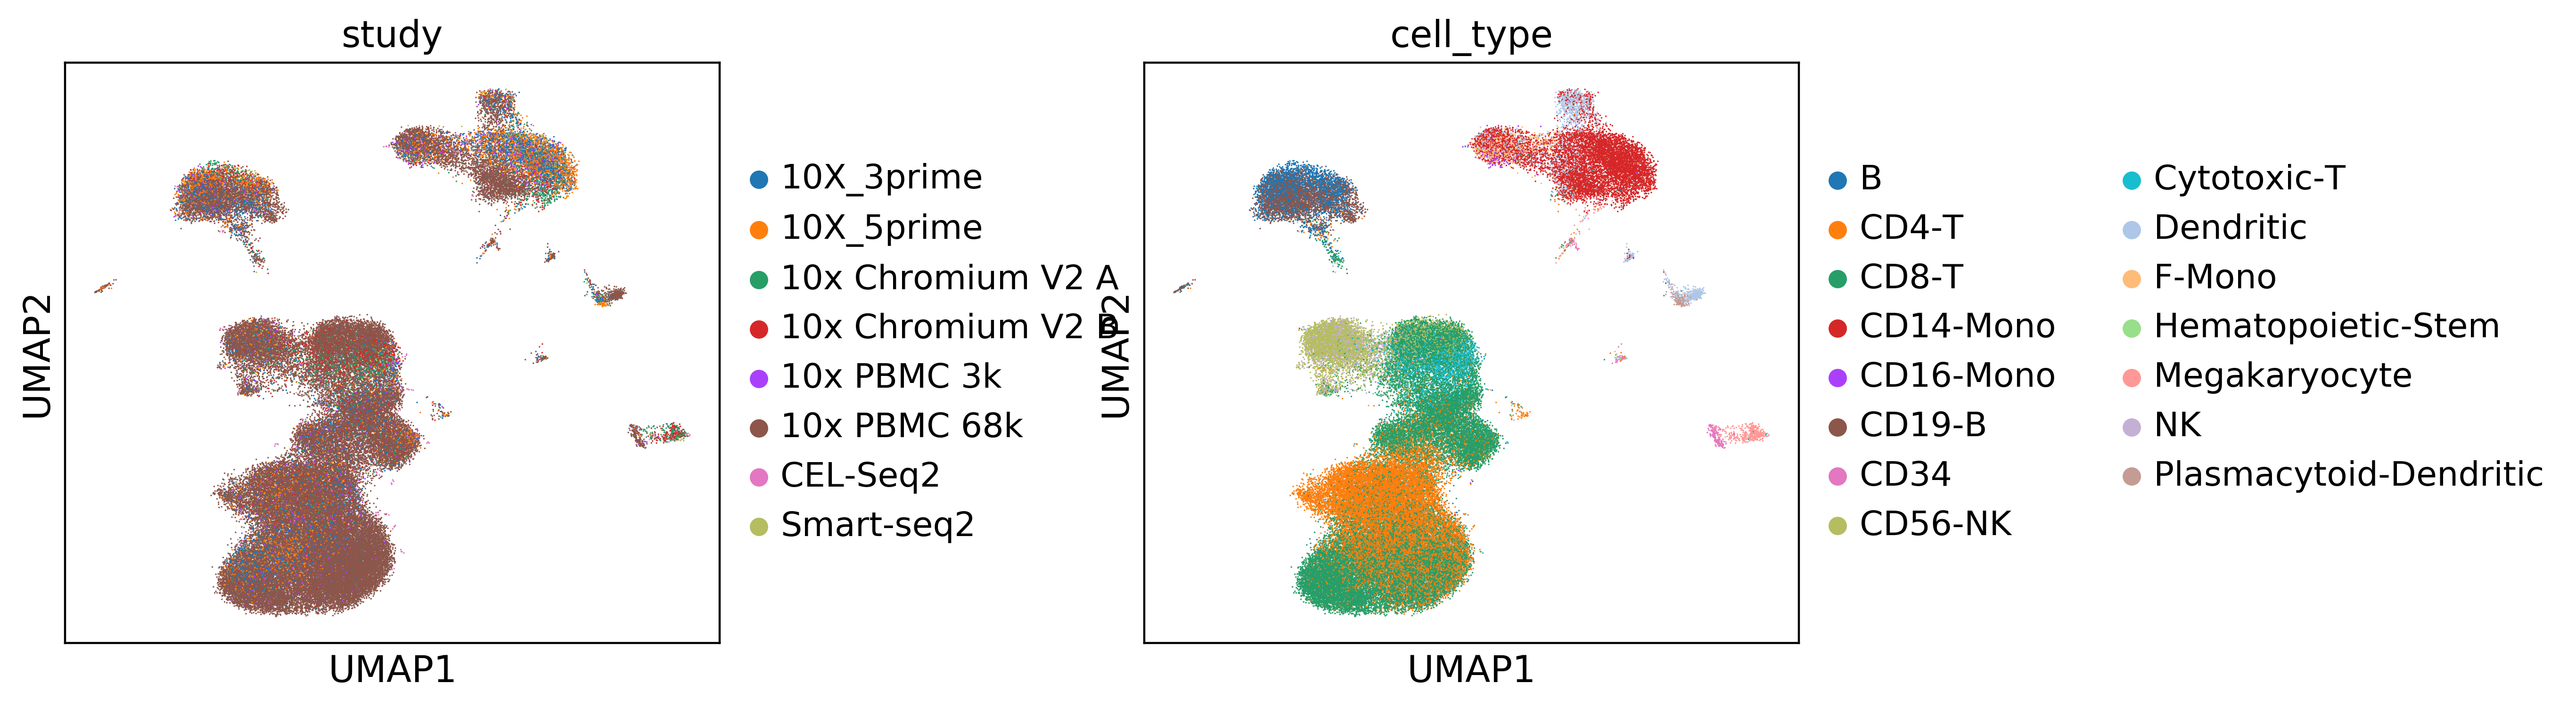

In [19]:
sc.pl.umap(latent_adata, color=[condition_key, cell_type_key], wspace=0.5)

# Perfroming architecture Surgery

In [20]:
new_network = surgeon.operate(network, 
                              new_conditions=target_conditions,
                              init='Xavier', 
                              freeze=True)
new_network.model_path = "./models/CVAE/PBMC/after/"

/home/mohsen/scnet/surgeon/models/_cvae.py:149: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("de...)`
  output=h_disp)


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               (None, 1793)         0                                            
__________________________________________________________________________________________________
encoder_labels (InputLayer)     (None, 10)           0                                            
__________________________________________________________________________________________________
concatenate_3 (Concatenate)     (None, 1803)         0           data[0][0]                       
                                                                 encoder_labels[0][0]             
__________________________________________________________________________________________________
first_layer (Dense)             (None, 512)          923136      concatenate_3[0][0]              
__________

In [21]:
new_network.condition_encoder

{'10x Chromium V2 A': 0,
 '10x Chromium V2 B': 1,
 'CEL-Seq2': 2,
 'Smart-seq2': 3,
 '10X_5prime': 4,
 '10X_3prime': 5,
 '10x PBMC 68k': 6,
 '10x PBMC 3k': 7,
 'Drop-seq': 8,
 'inDrops': 9}

## Train with small new dataset containing out-of-sample condition

In [22]:
train_adata, valid_adata = surgeon.utils.train_test_split(adata_out_of_sample, 0.85)

In [23]:
train_adata.shape, valid_adata.shape

((11192, 1793), (1976, 1793))

In [24]:
new_network.train(train_adata,
                  valid_adata, 
                  condition_key=condition_key,
                  le=new_network.condition_encoder, 
                  n_epochs=300,
                  batch_size=32, 
                  early_stop_limit=30,
                  lr_reducer=20, 
                  n_per_epoch=0,
                  save=True, 
                  verbose=2)

Train on 11192 samples, validate on 1976 samples
Epoch 1/300
 - 3s - loss: 2.2238 - nb: 2.2238 - val_loss: 1.5850 - val_nb: 1.5850
Epoch 2/300
 - 2s - loss: 1.7173 - nb: 1.7173 - val_loss: 1.6570 - val_nb: 1.6570
Epoch 3/300
 - 2s - loss: 1.6065 - nb: 1.6065 - val_loss: 1.6006 - val_nb: 1.6006
Epoch 4/300
 - 2s - loss: 1.5530 - nb: 1.5530 - val_loss: 1.5695 - val_nb: 1.5695
Epoch 5/300
 - 2s - loss: 1.5189 - nb: 1.5189 - val_loss: 1.5087 - val_nb: 1.5087
Epoch 6/300
 - 2s - loss: 1.5036 - nb: 1.5036 - val_loss: 1.4871 - val_nb: 1.4871
Epoch 7/300
 - 2s - loss: 1.4934 - nb: 1.4934 - val_loss: 1.4782 - val_nb: 1.4782
Epoch 8/300
 - 2s - loss: 1.4846 - nb: 1.4846 - val_loss: 1.4566 - val_nb: 1.4566
Epoch 9/300
 - 2s - loss: 1.4710 - nb: 1.4710 - val_loss: 1.4532 - val_nb: 1.4532
Epoch 10/300
 - 2s - loss: 1.4599 - nb: 1.4599 - val_loss: 1.4718 - val_nb: 1.4718
Epoch 11/300
 - 2s - loss: 1.4619 - nb: 1.4619 - val_loss: 1.4655 - val_nb: 1.4655
Epoch 12/300
 - 2s - loss: 1.4480 - nb: 1.4480 

In [25]:
encoder_labels, _ = surgeon.utils.label_encoder(adata_out_of_sample, label_encoder=new_network.condition_encoder, condition_key=condition_key)

In [26]:
latent_adata = new_network.to_latent(adata_out_of_sample, encoder_labels)
latent_adata

AnnData object with n_obs × n_vars = 13168 × 20 
    obs: 'CBC', 'CellType', 'Experiment', 'Method', 'batch', 'bulk_labels', 'cell_type', 'louvain', 'method', 'n_counts', 'n_genes', 'percent_mito', 'study', 'size_factors'

In [27]:
sc.pp.neighbors(latent_adata)
sc.tl.umap(latent_adata)

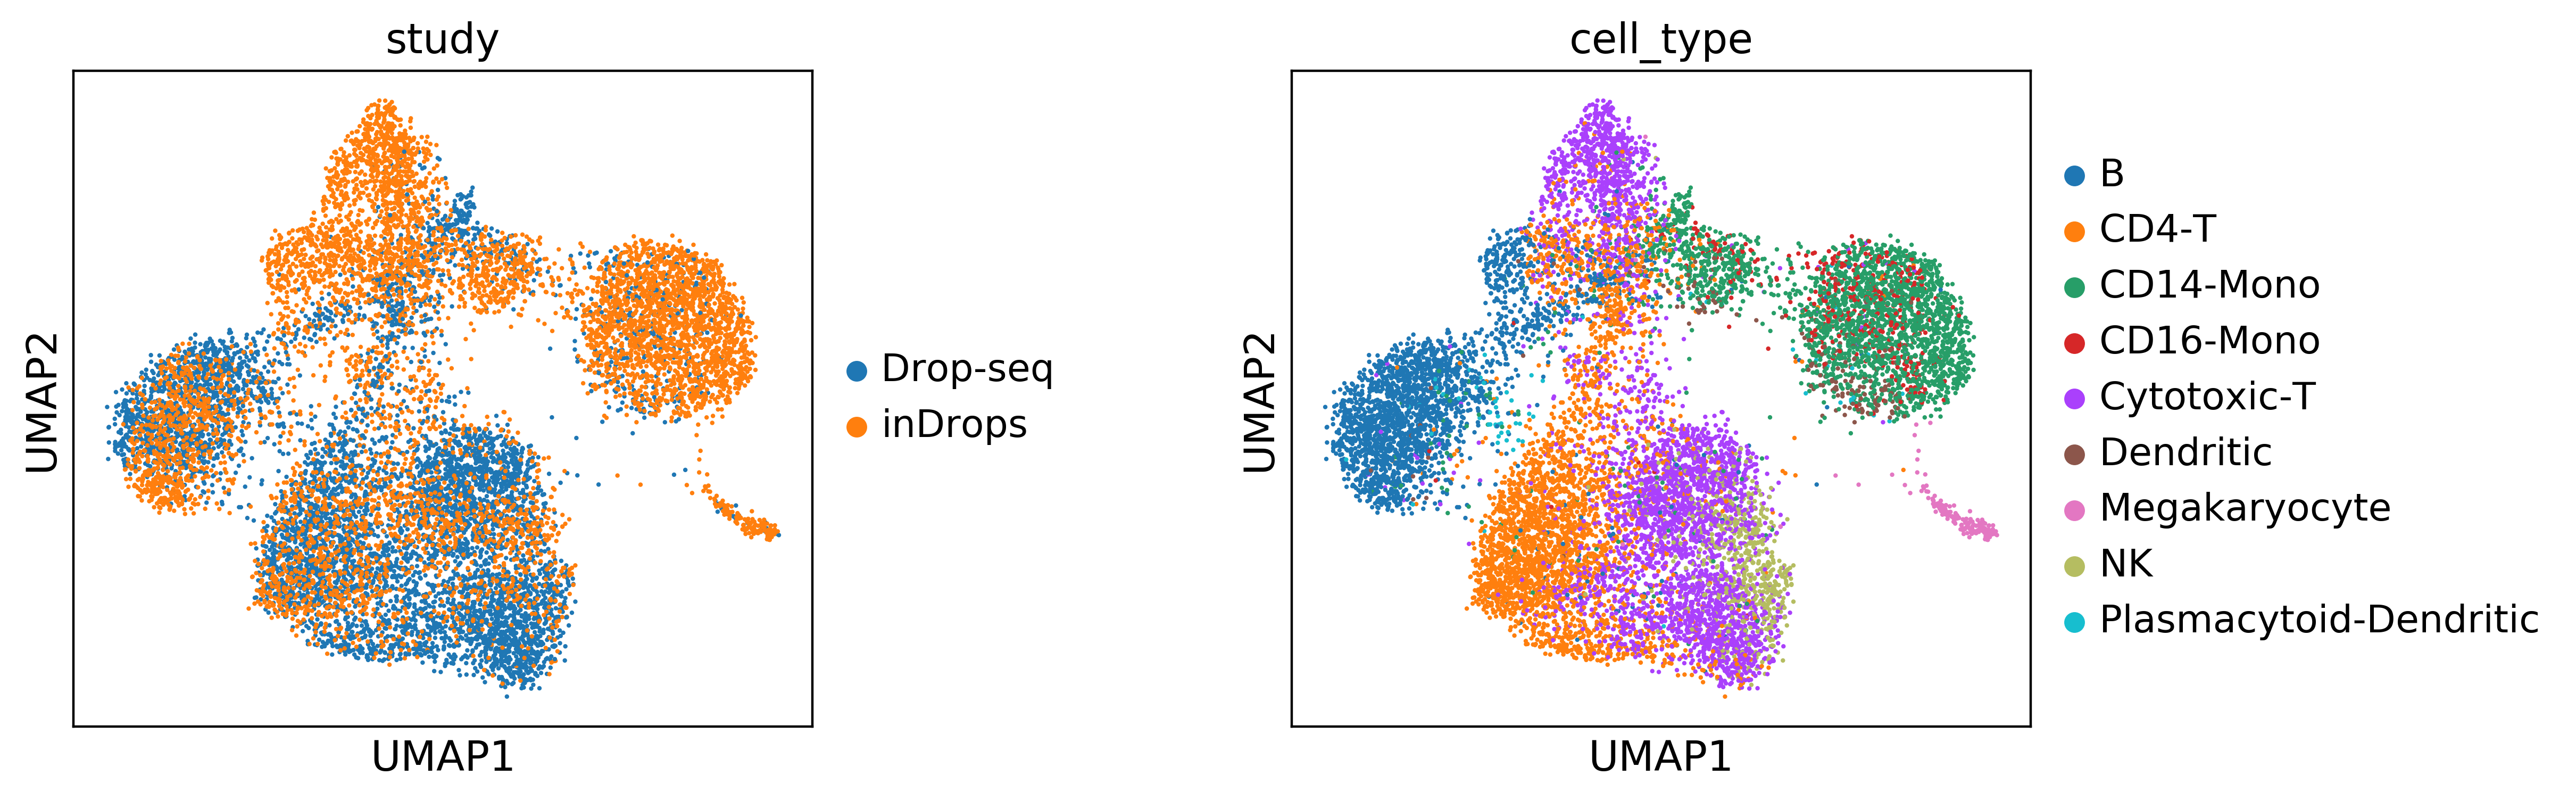

In [28]:
sc.pl.umap(latent_adata, color=[condition_key, cell_type_key], wspace=0.5)